# Federated Learning for Melanoma Classification

## Federated Learning scenario Data splits

### Objective 2: Developing IID data partitions to test Federated Learning
### Objective 3: Developing non-IID data scenarios to explore data distribution challenge


### Notes:
- We simulate different scenario to split the training data across different client.
- We create both random and non iid data splits and compare the different scenarios in term of feature and label distribution to measures  the heterogeneity of client data sets.

### Import Modules & Packages

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import time
import pickle
import random
import sklearn


from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import  confusion_matrix, roc_curve
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as tf
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations as A
from torch.cuda import amp
from tqdm.notebook import tqdm

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from utils import *
from Visualise import *
from ResizeImages import *
from MelanomaDataset import *
from MelanomaEfficientNet import *
from TrainVal import *
from Test import *
from Plot import *
from FLWorker import *
from FLScenario import *
from FedAvg import *
from FLutils import *
from FLTrainVal import *
from FocalLoss import *

### Package Versions

In [2]:
print(f"Python: {sys.version}")
print(f"Numpy Version: {np.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
print(f"sklearn: {sklearn.__version__}")
print(f"Torch: {torch.__version__}")

Python: 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
Numpy Version: 1.21.2
matplotlib: 3.4.3
sklearn: 0.24.2
Torch: 1.8.0+cu111


In [3]:
# Working directory
os.getcwd()

'C:\\Users\\sarah\\Documents\\MSc AI 2020_2021\\Research Project\\Federated-Learning-Melanoma'

In [4]:
# Seed everything
set_seed(random_seed=5)

In [5]:
# Set device to GPU if available
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Method 1: Generating Random Splits across workers (Simulating IID)
### Split per Patient ID - Real-world scenario
### Splits performed for 6, 12, 24, 48 and 96 client workers.

In [60]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)



n_workers = 6
random_sc = RandomScenarioFL(split_by='patient_id')
random_workers_split6 = create_flworker_set(train_loader,n_workers,random_sc,10)


In [61]:
# Table showing the ratio of each feature and the ratio of target 1 in the label of each client dataset
workers_feature_label_dist(random_workers_split6)

,sex (female),age_approx (mean),age_approx (std),upper extremity,lower extremity,torso,unknown,head/neck,palms/soles,oral/genital,target (1),Total patients
0,0.415796,50.447154,13.910333,0.144890,0.265970,0.505517,0.014228,0.054878,0.011614,0.002904,0.020035,239
1,0.503568,49.867983,13.623290,0.143673,0.269981,0.491675,0.034967,0.046147,0.010466,0.003092,0.015937,239
2,0.439908,48.588926,15.231720,0.141107,0.255167,0.514417,0.012503,0.064047,0.010972,0.001786,0.017607,239
3,0.485760,48.424234,14.319493,0.132724,0.265717,0.512628,0.020956,0.050779,0.012896,0.004299,0.019613,239
4,0.522943,48.719559,14.406010,0.155857,0.239169,0.532428,0.007947,0.041784,0.015124,0.007690,0.014099,239
5,0.529350,48.375262,14.342530,0.169811,0.247379,0.508910,0.011006,0.053197,0.007075,0.002621,0.019392,239


In [62]:
#table summarizing the JSD for each feature label per client from the train dataset
jsd_iid_w6 = ws_jensen_shanon_distance(train_loader,random_workers_split6,output='workers_distances')
jsd_iid_w6

,sex_dist,age_dist,anatom_dist,target_dist
0,3.503531e-03,0.008346,0.000249,5.205493e-05
1,2.456733e-04,0.004429,0.002584,3.478276e-05
2,1.483046e-03,0.003575,0.001080,1.416343e-07
3,3.006275e-07,0.000908,0.000519,3.517201e-05
4,1.032519e-03,0.003733,0.002867,1.516114e-04
5,1.412246e-03,0.006079,0.001571,2.758213e-05


In [63]:
ws_jensen_shanon_distance(train_loader,random_workers_split6,output='max')

{'sex_dist': 0.0035035313591110246,
 'age_dist': 0.008346297555419631,
 'anatom_dist': 0.00286712483761636,
 'target_dist': 0.00015161139754854222}

In [64]:
# Runing random splits per patient for different number of workers

In [65]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)



n_workers = 12
random_sc = RandomScenarioFL(split_by='patient_id')
random_workers_split = create_flworker_set(train_loader,n_workers,random_sc,10)
jsd_iid_w12 = ws_jensen_shanon_distance(train_loader,random_workers_split,output='workers_distances')

In [66]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)



n_workers = 24
random_sc = RandomScenarioFL(split_by='patient_id')
random_workers_split = create_flworker_set(train_loader,n_workers,random_sc,10)
jsd_iid_w24 = ws_jensen_shanon_distance(train_loader,random_workers_split,output='workers_distances')

In [67]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)



n_workers = 48
random_sc = RandomScenarioFL(split_by='patient_id')
random_workers_split = create_flworker_set(train_loader,n_workers,random_sc,10)
jsd_iid_w48 = ws_jensen_shanon_distance(train_loader,random_workers_split,output='workers_distances')

In [68]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)



n_workers = 96
random_sc = RandomScenarioFL(split_by='patient_id')
random_workers_split = create_flworker_set(train_loader,n_workers,random_sc,10)
jsd_iid_w96 = ws_jensen_shanon_distance(train_loader,random_workers_split,output='workers_distances')

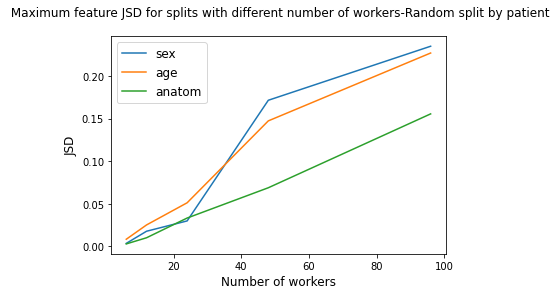

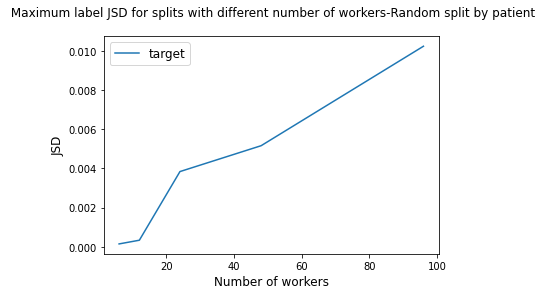

In [177]:
dfs = [jsd_iid_w6,jsd_iid_w12,jsd_iid_w24,jsd_iid_w48,jsd_iid_w96]
workers = [6,12,24,48,96]
metrics_iid_patient={'sex_dist':[[],[]],'age_dist':[[],[]],'anatom_dist':[[],[]],'target_dist':[[],[]]}

for key in metrics_iid_patient:
    
    metrics_iid_patient[key][0]=[df[key].min() for df in dfs]
    metrics_iid_patient[key][1]=[df[key].max() for df in dfs]
    
for key in metrics_iid_patient:
    if(key!='target_dist'):
        plt.plot(workers,metrics_iid_patient[key][1],label=key.split("_")[0])

t = " Maximum feature JSD for splits with different number of workers-Random split by patient"
plt.title(t, pad=20)
plt.legend(fontsize=12)
plt.xlabel("Number of workers", fontsize=12)
plt.ylabel("JSD", fontsize=12)
plt.show()

plt.plot(workers,metrics_iid_patient['target_dist'][1],label='target')

t = " Maximum label JSD for splits with different number of workers-Random split by patient"
plt.title(t, pad=20)
plt.legend(fontsize=12)
plt.xlabel("Number of workers", fontsize=12)
plt.ylabel("JSD", fontsize=12)
plt.show()

### Split per Image ID - Theoretical scenario
### Splits performed for 6, 12, 24, 48 and 96 client workers.

In [72]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)



n_workers = 6
random_sc = RandomScenarioFL(split_by='image_name')
random_workers_split = create_flworker_set(train_loader,n_workers,random_sc,10)
jsd_iid_w6_image = ws_jensen_shanon_distance(train_loader,random_workers_split,output='workers_distances')

In [73]:
# Table showing the ratio of each feature and the ratio of target 1 in the label of each client dataset
workers_feature_label_dist(random_workers_split)

,sex (female),age_approx (mean),age_approx (std),upper extremity,lower extremity,torso,unknown,head/neck,palms/soles,oral/genital,target (1),Total patients
0,0.477899,48.935257,14.378452,0.153666,0.270151,0.499740,0.016901,0.043422,0.012741,0.00338,0.019501,1147
1,0.496100,49.135465,14.431133,0.155746,0.247790,0.513261,0.014301,0.054342,0.012220,0.00234,0.018201,1099
2,0.488560,49.030161,14.363229,0.143266,0.266511,0.504940,0.016641,0.050962,0.011960,0.00572,0.016121,1114
3,0.496880,49.000260,14.296516,0.151326,0.252730,0.503900,0.019761,0.059022,0.009100,0.00416,0.016901,1104
4,0.476599,48.788352,14.423501,0.142746,0.249610,0.529381,0.017941,0.044982,0.012741,0.00260,0.020021,1109
5,0.474779,49.318773,14.253557,0.140146,0.259490,0.511180,0.018461,0.057462,0.009100,0.00416,0.015601,1147


In [74]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)



n_workers = 12
random_sc = RandomScenarioFL(split_by='image_name')
random_workers_split = create_flworker_set(train_loader,n_workers,random_sc,10)
jsd_iid_w12_image = ws_jensen_shanon_distance(train_loader,random_workers_split,output='workers_distances')

In [75]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)



n_workers = 24
random_sc = RandomScenarioFL(split_by='image_name')
random_workers_split = create_flworker_set(train_loader,n_workers,random_sc,10)
jsd_iid_w24_image = ws_jensen_shanon_distance(train_loader,random_workers_split,output='workers_distances')

In [76]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)



n_workers = 48
random_sc = RandomScenarioFL(split_by='image_name')
random_workers_split = create_flworker_set(train_loader,n_workers,random_sc,10)
jsd_iid_w48_image = ws_jensen_shanon_distance(train_loader,random_workers_split,output='workers_distances')

In [77]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)



n_workers = 96
random_sc = RandomScenarioFL(split_by='image_name')
random_workers_split = create_flworker_set(train_loader,n_workers,random_sc,10)
jsd_iid_w96_image = ws_jensen_shanon_distance(train_loader,random_workers_split,output='workers_distances')

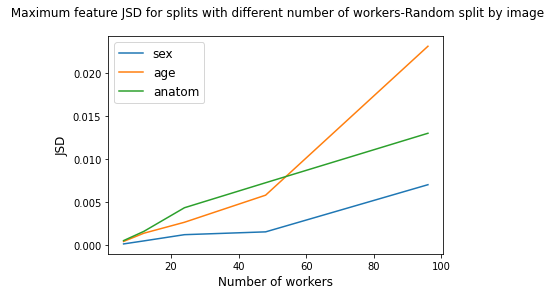

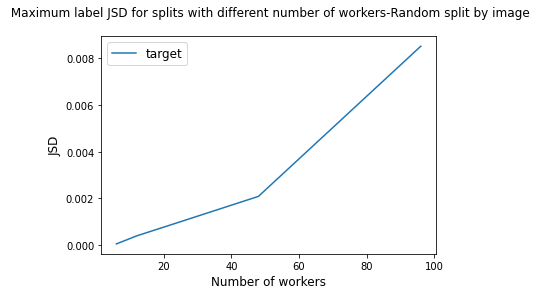

In [176]:
dfs = [jsd_iid_w6_image,jsd_iid_w12_image,jsd_iid_w24_image,jsd_iid_w48_image,jsd_iid_w96_image]
workers = [6,12,24,48,96]
metrics_iid_image={'sex_dist':[[],[]],'age_dist':[[],[]],'anatom_dist':[[],[]],'target_dist':[[],[]]}

for key in metrics_iid_image:
    
    metrics_iid_image[key][0]=[df[key].min() for df in dfs]
    metrics_iid_image[key][1]=[df[key].max() for df in dfs]
    
for key in metrics_iid_image:
    if(key!='target_dist'):
        plt.plot(workers,metrics_iid_image[key][1],label=key.split("_")[0])

t = " Maximum feature JSD for splits with different number of workers-Random split by image"
plt.title(t, pad=20)
plt.legend(fontsize=12)
plt.xlabel("Number of workers", fontsize=12)
plt.ylabel("JSD", fontsize=12)
plt.show()

plt.plot(workers,metrics_iid_image['target_dist'][1],label='target')

t = " Maximum label JSD for splits with different number of workers-Random split by image"
plt.title(t, pad=20)
plt.legend(fontsize=12)
plt.xlabel("Number of workers", fontsize=12)
plt.ylabel("JSD", fontsize=12)
plt.show()

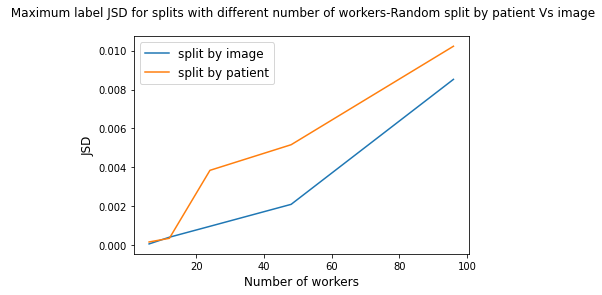

In [99]:
plt.plot(workers,metrics_iid_image['target_dist'][1],label='split by image')
plt.plot(workers,metrics_iid_patient['target_dist'][1],label='split by patient')

t = " Maximum label JSD for splits with different number of workers-Random split by patient Vs image"
plt.title(t, pad=20)
plt.legend(fontsize=12)
plt.xlabel("Number of workers", fontsize=12)
plt.ylabel("JSD", fontsize=12)
plt.show()

- The results show that random split generates IID datasets when the number of clients is small, however for large number of clients the datasets in the split will diverge from training dataset distribution.
- Datasets where splits are performed by patient ID show higher divergence from the train dataset compared to split per Image IID. This is due to the fact different clients may have different number of images and different distributions for label and features like anatomical site.


## Method 2: Exploring Label Distribution Skew
### IID split with Dirichlet distribution applied to the label
### Symmetrical Dirichlet distribution with very high concentration parameter allows to generate IID scenarios#
### Splits performed for 6, 12, 24, 48 and 96 client workers.

In [84]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)



n_workers = 6
dirichlet_sc = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=100000,split_by='image_name')
dirichlet_workers_split = create_flworker_set(train_loader,n_workers,dirichlet_sc,10)
jsd_iid_w6_image_d_inf = ws_jensen_shanon_distance(train_loader,dirichlet_workers_split,output='workers_distances')

In [85]:
workers_feature_label_dist(dirichlet_workers_split)

,sex (female),age_approx (mean),age_approx (std),upper extremity,lower extremity,torso,unknown,head/neck,palms/soles,oral/genital,target (1),Total patients
0,0.471659,48.995060,14.092310,0.156266,0.249870,0.505200,0.018461,0.056942,0.010660,0.00260,0.017681,1138
1,0.490120,48.866355,14.467194,0.158346,0.258970,0.495320,0.015341,0.056422,0.011440,0.00416,0.017941,1107
2,0.482579,49.035361,14.320965,0.136505,0.255850,0.524441,0.015341,0.049402,0.014041,0.00442,0.017681,1095
3,0.481019,48.675247,14.207046,0.144306,0.260010,0.515341,0.018201,0.047322,0.011700,0.00312,0.017681,1126
4,0.488560,49.216069,14.635684,0.146386,0.267551,0.509360,0.015601,0.048882,0.007540,0.00468,0.017681,1130
5,0.496620,49.421477,14.410730,0.145346,0.254030,0.512741,0.020801,0.051222,0.012480,0.00338,0.017681,1116


In [86]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)



n_workers = 12
dirichlet_sc = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=100000,split_by='image_name')
dirichlet_workers_split = create_flworker_set(train_loader,n_workers,dirichlet_sc,10)
jsd_iid_w12_image_d_inf = ws_jensen_shanon_distance(train_loader,dirichlet_workers_split,output='workers_distances')

In [87]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)



n_workers = 24
dirichlet_sc = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=100000,split_by='image_name')
dirichlet_workers_split = create_flworker_set(train_loader,n_workers,dirichlet_sc,10)
jsd_iid_w24_image_d_inf = ws_jensen_shanon_distance(train_loader,dirichlet_workers_split,output='workers_distances')

In [88]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)



n_workers = 48
dirichlet_sc = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=100000,split_by='image_name')
dirichlet_workers_split = create_flworker_set(train_loader,n_workers,dirichlet_sc,10)
jsd_iid_w48_image_d_inf = ws_jensen_shanon_distance(train_loader,dirichlet_workers_split,output='workers_distances')

In [89]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)



n_workers = 96
dirichlet_sc = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=100000,split_by='image_name')
dirichlet_workers_split = create_flworker_set(train_loader,n_workers,dirichlet_sc,10)
jsd_iid_w96_image_d_inf = ws_jensen_shanon_distance(train_loader,dirichlet_workers_split,output='workers_distances')

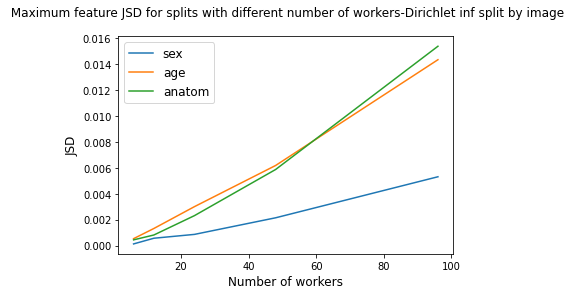

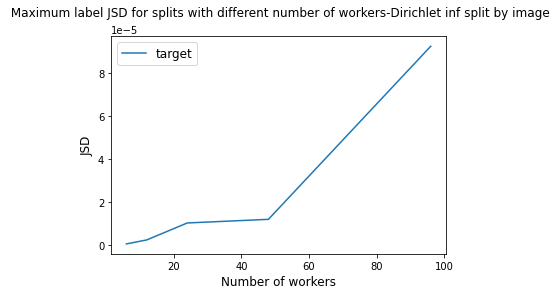

In [138]:
dfs = [jsd_iid_w6_image_d_inf,jsd_iid_w12_image_d_inf,jsd_iid_w24_image_d_inf,jsd_iid_w48_image_d_inf,jsd_iid_w96_image_d_inf]
workers = [6,12,24,48,96]
metrics_iid_image_d_inf={'sex_dist':[[],[]],'age_dist':[[],[]],'anatom_dist':[[],[]],'target_dist':[[],[]]}

for key in metrics_iid_image_d_inf:
    
    metrics_iid_image_d_inf[key][0]=[df[key].min() for df in dfs]
    metrics_iid_image_d_inf[key][1]=[df[key].max() for df in dfs]
    
for key in metrics_iid_image_d_inf:
    if(key!='target_dist'):
        plt.plot(workers,metrics_iid_image_d_inf[key][1],label=key.split("_")[0])

t = " Maximum feature JSD for splits with different number of workers-Dirichlet inf split by image"
plt.title(t, pad=20)
plt.legend(fontsize=12)
plt.xlabel("Number of workers", fontsize=12)
plt.ylabel("JSD", fontsize=12)
plt.show()

plt.plot(workers,metrics_iid_image_d_inf['target_dist'][1],label='target')

t = " Maximum label JSD for splits with different number of workers-Dirichlet inf split by image"
plt.title(t, pad=20)
plt.legend(fontsize=12)
plt.xlabel("Number of workers", fontsize=12)
plt.ylabel("JSD", fontsize=12)
plt.show()

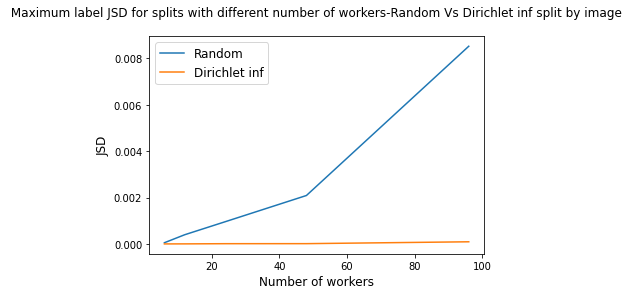

In [139]:
plt.plot(workers,metrics_iid_image['target_dist'][1],label='Random')
plt.plot(workers,metrics_iid_image_d_inf['target_dist'][1],label='Dirichlet inf')

t = " Maximum label JSD for splits with different number of workers-Random Vs Dirichlet inf split by image "
plt.title(t, pad=20)
plt.legend(fontsize=12)
plt.xlabel("Number of workers", fontsize=12)
plt.ylabel("JSD", fontsize=12)
plt.show()

Splitting data with probabilities similuated by Dirichlet with infinite concentration parameters can simulate better the iid case even for high numbe of workers. We will therefore use it as method to test different federated learning algorithms for the iid case. 

## Generating Label Imbalance
### Non IID split with Dirichlet distribution
#### Split per Image ID for different alpha parameters to demonstrates effectiveness as an indicator for heterogeneity. Performed for 6 workers.

In [119]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)



n_workers = 6
dirichlet_sc = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=1,split_by='image_name')
dirichlet_workers_split = create_flworker_set(train_loader,n_workers,dirichlet_sc,10)
jsd_iid_w6_image_d_1 = ws_jensen_shanon_distance(train_loader,dirichlet_workers_split,output='workers_distances')

In [120]:
workers_feature_label_dist(dirichlet_workers_split)

,sex (female),age_approx (mean),age_approx (std),upper extremity,lower extremity,torso,unknown,head/neck,palms/soles,oral/genital,target (1),Total patients
0,0.472439,48.905356,14.041010,0.156006,0.250390,0.504680,0.018461,0.056942,0.010660,0.00286,0.011440,1137
1,0.495840,48.694748,14.430657,0.156266,0.260010,0.499740,0.014821,0.053822,0.011440,0.00390,0.000520,1091
2,0.483099,49.018461,14.228944,0.137025,0.255590,0.523661,0.015861,0.049662,0.013781,0.00442,0.012220,1091
3,0.471399,49.132865,14.439084,0.146386,0.257410,0.511440,0.018461,0.051482,0.011700,0.00312,0.062663,1159
4,0.490120,49.080863,14.598002,0.146126,0.268591,0.509880,0.015601,0.047322,0.007800,0.00468,0.004160,1124
5,0.497660,49.377275,14.398956,0.145346,0.254290,0.513001,0.020541,0.050962,0.012480,0.00338,0.015341,1113


In [121]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)



n_workers = 6
dirichlet_sc = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=1.5,split_by='image_name')
dirichlet_workers_split = create_flworker_set(train_loader,n_workers,dirichlet_sc,10)
jsd_iid_w6_image_d_1_5 = ws_jensen_shanon_distance(train_loader,dirichlet_workers_split,output='workers_distances')

In [122]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)



n_workers = 6
dirichlet_sc = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=0.75,split_by='image_name')
dirichlet_workers_split = create_flworker_set(train_loader,n_workers,dirichlet_sc,10)
jsd_iid_w6_image_d_0_75 = ws_jensen_shanon_distance(train_loader,dirichlet_workers_split,output='workers_distances')

In [123]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)



n_workers = 6
dirichlet_sc = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=0.5,split_by='image_name')
dirichlet_workers_split = create_flworker_set(train_loader,n_workers,dirichlet_sc,10)
jsd_iid_w6_image_d_0_5 = ws_jensen_shanon_distance(train_loader,dirichlet_workers_split,output='workers_distances')

In [124]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)



n_workers = 6
dirichlet_sc = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=0.25,split_by='image_name')
dirichlet_workers_split = create_flworker_set(train_loader,n_workers,dirichlet_sc,10)
jsd_iid_w6_image_d_0_25 = ws_jensen_shanon_distance(train_loader,dirichlet_workers_split,output='workers_distances')

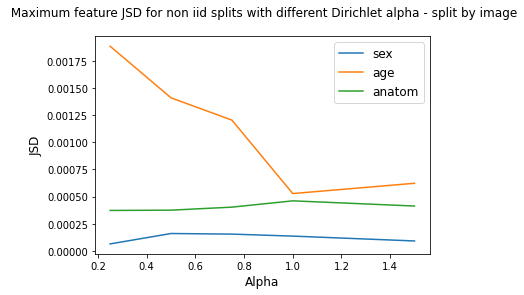

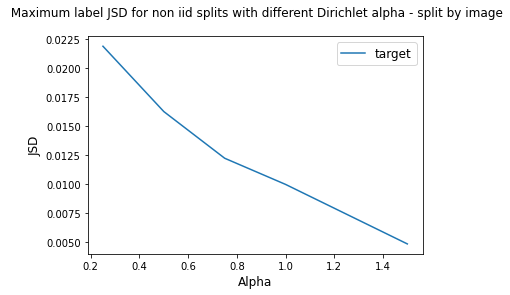

In [153]:
dfs = [jsd_iid_w6_image_d_0_25,jsd_iid_w6_image_d_0_5,jsd_iid_w6_image_d_0_75,jsd_iid_w6_image_d_1,jsd_iid_w6_image_d_1_5]
alpha = [0.25,0.5,0.75,1,1.5]
metrics_non_iid_image_d_inf={'sex_dist':[[],[]],'age_dist':[[],[]],'anatom_dist':[[],[]],'target_dist':[[],[]]}

for key in metrics_non_iid_image_d_inf:
    
    metrics_non_iid_image_d_inf[key][0]=[df[key].min() for df in dfs]
    metrics_non_iid_image_d_inf[key][1]=[df[key].max() for df in dfs]
    
for key in metrics_non_iid_image_d_inf:
    if(key!='target_dist'):
        plt.plot(alpha,metrics_non_iid_image_d_inf[key][1],label=key.split("_")[0])

t = " Maximum feature JSD for non iid splits with different Dirichlet alpha - split by image"
plt.title(t, pad=20)
plt.legend(fontsize=12)
plt.xlabel("Alpha", fontsize=12)
plt.ylabel("JSD", fontsize=12)
plt.show()

plt.plot(alpha,metrics_non_iid_image_d_inf['target_dist'][1],label='target')

t = " Maximum label JSD for non iid splits with different Dirichlet alpha - split by image"
plt.title(t, pad=20)
plt.legend(fontsize=12)
plt.xlabel("Alpha", fontsize=12)
plt.ylabel("JSD", fontsize=12)
plt.show()

### Dirichlet 0.5 split across different number of client workers 6, 12, 24, 48 and 96

In [228]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)



n_workers = 12
dirichlet_sc = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=0.5,split_by='image_name')
dirichlet_workers_split = create_flworker_set(train_loader,n_workers,dirichlet_sc,10)
jsd_iid_w12_image_d_0_5 = ws_jensen_shanon_distance(train_loader,dirichlet_workers_split,output='workers_distances')

train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)



n_workers = 24
dirichlet_sc = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=0.5,split_by='image_name')
dirichlet_workers_split = create_flworker_set(train_loader,n_workers,dirichlet_sc,10)
jsd_iid_w24_image_d_0_5 = ws_jensen_shanon_distance(train_loader,dirichlet_workers_split,output='workers_distances')

train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)



n_workers = 48
dirichlet_sc = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=0.5,split_by='image_name')
dirichlet_workers_split = create_flworker_set(train_loader,n_workers,dirichlet_sc,10)
jsd_iid_w48_image_d_0_5 = ws_jensen_shanon_distance(train_loader,dirichlet_workers_split,output='workers_distances')

train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)



n_workers = 96
dirichlet_sc = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=0.5,split_by='image_name')
dirichlet_workers_split = create_flworker_set(train_loader,n_workers,dirichlet_sc,10)
jsd_iid_w96_image_d_0_5 = ws_jensen_shanon_distance(train_loader,dirichlet_workers_split,output='workers_distances')

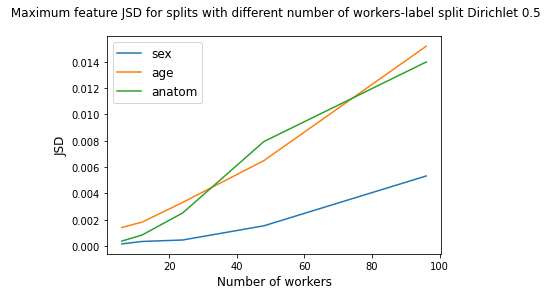

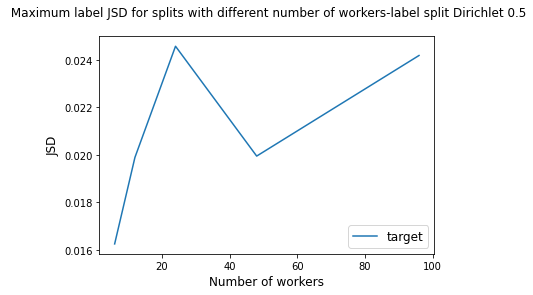

In [229]:
dfs = [jsd_iid_w6_image_d_0_5,jsd_iid_w12_image_d_0_5,jsd_iid_w24_image_d_0_5,jsd_iid_w48_image_d_0_5,jsd_iid_w96_image_d_0_5]
workers = [6,12,24,48,96]
metrics_da0_5_image={'sex_dist':[[],[]],'age_dist':[[],[]],'anatom_dist':[[],[]],'target_dist':[[],[]]}

for key in metrics_da0_5_image:
    
    metrics_da0_5_image[key][0]=[df[key].min() for df in dfs]
    metrics_da0_5_image[key][1]=[df[key].max() for df in dfs]
    
for key in metrics_da0_5_image:
    if(key!='target_dist'):
        plt.plot(workers,metrics_da0_5_image[key][1],label=key.split("_")[0])

t = " Maximum feature JSD for splits with different number of workers-label split Dirichlet 0.5"
plt.title(t, pad=20)
plt.legend(fontsize=12)
plt.xlabel("Number of workers", fontsize=12)
plt.ylabel("JSD", fontsize=12)
plt.show()

plt.plot(workers,metrics_da0_5_image['target_dist'][1],label='target')

t = " Maximum label JSD for splits with different number of workers-label split Dirichlet 0.5"
plt.title(t, pad=20)
plt.legend(fontsize=12)
plt.xlabel("Number of workers", fontsize=12)
plt.ylabel("JSD", fontsize=12)
plt.show()


#### Split per Patient ID for different alpha parameters to demonstrates effectiveness as an indicator for heterogeneity. Performed for 6 workers.

In [141]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)



n_workers = 6
dirichlet_sc = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=1,split_by='patient_id')
dirichlet_workers_split = create_flworker_set(train_loader,n_workers,dirichlet_sc,10)
jsd_iid_w6_patient_d_1 = ws_jensen_shanon_distance(train_loader,dirichlet_workers_split,output='workers_distances')

In [142]:
workers_feature_label_dist(dirichlet_workers_split)

,sex (female),age_approx (mean),age_approx (std),upper extremity,lower extremity,torso,unknown,head/neck,palms/soles,oral/genital,target (1),Total patients
0,0.426270,49.913913,14.649358,0.151069,0.269925,0.493752,0.009720,0.059706,0.009442,0.006387,0.035823,239
1,0.530597,47.348259,14.941059,0.151493,0.256965,0.516915,0.008458,0.048259,0.013433,0.004478,0.013184,239
2,0.524814,48.287338,13.590739,0.137059,0.249536,0.538033,0.013451,0.048933,0.010900,0.002087,0.003942,239
3,0.518934,48.885186,14.562275,0.143896,0.262648,0.507119,0.018782,0.054226,0.012420,0.000909,0.006362,239
4,0.375818,49.754059,13.731069,0.149503,0.245457,0.496002,0.043858,0.051611,0.009692,0.003877,0.008238,239
5,0.538024,50.144790,14.583623,0.155345,0.265223,0.505548,0.008119,0.048985,0.012179,0.004601,0.041949,239


In [143]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)



n_workers = 6
dirichlet_sc = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=1.5,split_by='patient_id')
dirichlet_workers_split = create_flworker_set(train_loader,n_workers,dirichlet_sc,10)
jsd_iid_w6_patient_d_1_5 = ws_jensen_shanon_distance(train_loader,dirichlet_workers_split,output='workers_distances')

In [144]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)



n_workers = 6
dirichlet_sc = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=0.75,split_by='patient_id')
dirichlet_workers_split = create_flworker_set(train_loader,n_workers,dirichlet_sc,10)
jsd_iid_w6_patient_d_0_75 = ws_jensen_shanon_distance(train_loader,dirichlet_workers_split,output='workers_distances')

In [145]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)



n_workers = 6
dirichlet_sc = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=0.5,split_by='patient_id')
dirichlet_workers_split = create_flworker_set(train_loader,n_workers,dirichlet_sc,10)
jsd_iid_w6_patient_d_0_5 = ws_jensen_shanon_distance(train_loader,dirichlet_workers_split,output='workers_distances')

In [146]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)



n_workers = 6
dirichlet_sc = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=0.25,split_by='patient_id')
dirichlet_workers_split = create_flworker_set(train_loader,n_workers,dirichlet_sc,10)
jsd_iid_w6_patient_d_0_25 = ws_jensen_shanon_distance(train_loader,dirichlet_workers_split,output='workers_distances')

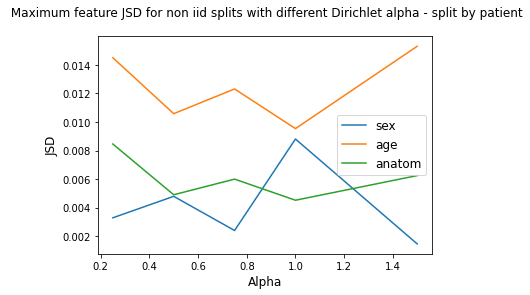

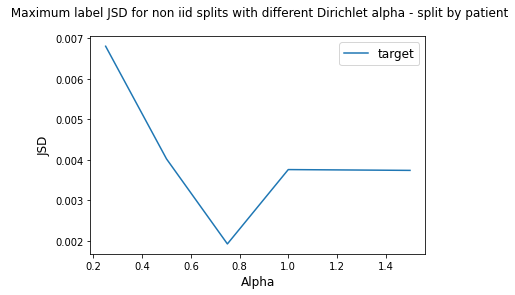

In [151]:
dfs = [jsd_iid_w6_patient_d_0_25,jsd_iid_w6_patient_d_0_5,jsd_iid_w6_patient_d_0_75,jsd_iid_w6_patient_d_1,jsd_iid_w6_patient_d_1_5]
alpha = [0.25,0.5,0.75,1,1.5]
metrics_non_iid_patient_d_inf={'sex_dist':[[],[]],'age_dist':[[],[]],'anatom_dist':[[],[]],'target_dist':[[],[]]}

for key in metrics_non_iid_patient_d_inf:
    
    metrics_non_iid_patient_d_inf[key][0]=[df[key].min() for df in dfs]
    metrics_non_iid_patient_d_inf[key][1]=[df[key].max() for df in dfs]
    
for key in metrics_non_iid_patient_d_inf:
    if(key!='target_dist'):
        plt.plot(alpha,metrics_non_iid_patient_d_inf[key][1],label=key.split("_")[0])

t = " Maximum feature JSD for non iid splits with different Dirichlet alpha - split by patient"
plt.title(t, pad=20)
plt.legend(fontsize=12)
plt.xlabel("Alpha", fontsize=12)
plt.ylabel("JSD", fontsize=12)
plt.show()

plt.plot(alpha,metrics_non_iid_patient_d_inf['target_dist'][1],label='target')

t = " Maximum label JSD for non iid splits with different Dirichlet alpha - split by patient"
plt.title(t, pad=20)
plt.legend(fontsize=12)
plt.xlabel("Alpha", fontsize=12)
plt.ylabel("JSD", fontsize=12)
plt.show()

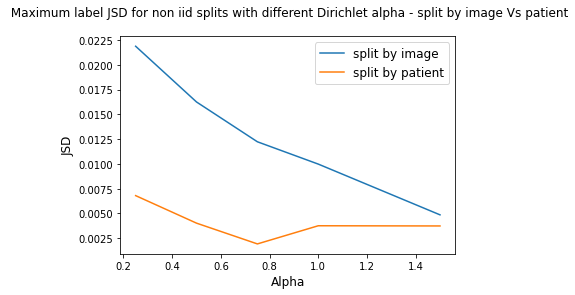

In [152]:
plt.plot(alpha,metrics_non_iid_image_d_inf['target_dist'][1],label='split by image')
plt.plot(alpha,metrics_non_iid_patient_d_inf['target_dist'][1],label='split by patient')

t = " Maximum label JSD for non iid splits with different Dirichlet alpha - split by image Vs patient"
plt.title(t, pad=20)
plt.legend(fontsize=12)
plt.xlabel("Alpha", fontsize=12)
plt.ylabel("JSD", fontsize=12)
plt.show()

- Having low ratio of image data with target 1 limits the maximum divergence and hiterogeniety we can achieve in the dataset splits with very low alpha
- Patient can have multiple images and only small number of these images as target 1, this limits the maximum divergence we can achieve with splits per patient Id. 
- Split by patient Id with alpha 0.25 is similar to split by image with alpha 1.5. 
- Conclusion alpha 0.5 with split per image will be our base case scenario to test Fed learning algorithm performance on non-iid data


## Method 3: Generating Unbalanced Data Splits
### Unbalanced data size splits by Patient ID across a number of workers 6, 12, 24, 48, 96
#### For 6 workers in a balanced dataset each worker has 240 patients, in order to generate imbalance we set a minimum worker amount for one client and distribute the remaining samples based on the DataScenarioFL formula 2*(Total Data Size)/(Number of clients)-lower data size.

In [197]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)



n_workers = 6
#lower data size set to be 20% of average data size
random_sc = RandomScenarioFL(split_by='patient_id',unbalanced_datasize=True,lower_datasize=40)
random_workers_split6 = create_flworker_set(train_loader,n_workers,random_sc,1)
jsd_uds_w6_patient = ws_jensen_shanon_distance(train_loader,random_workers_split6,output='workers_distances')

In [198]:
workers_feature_label_dist(random_workers_split6)

,sex (female),age_approx (mean),age_approx (std),upper extremity,lower extremity,torso,unknown,head/neck,palms/soles,oral/genital,target (1),Total patients
0,0.453863,50.192780,13.657778,0.143827,0.269170,0.495018,0.027726,0.050830,0.010253,0.003177,0.017617,435
1,0.449099,48.992275,14.865668,0.137339,0.260258,0.510558,0.017167,0.060944,0.011674,0.002060,0.018197,356
2,0.487475,48.164888,14.196445,0.141581,0.248530,0.536920,0.011327,0.042474,0.013287,0.005881,0.018079,277
3,0.560811,48.532095,14.754347,0.178378,0.253378,0.485135,0.009459,0.052703,0.015203,0.005743,0.013176,198
4,0.503876,50.382060,13.034928,0.150055,0.234219,0.546512,0.009967,0.050941,0.005537,0.002769,0.021595,119
5,0.584660,46.186686,16.863773,0.170767,0.272069,0.492041,0.007236,0.044863,0.008683,0.004342,0.023155,40


In [199]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)



n_workers = 12
random_sc = RandomScenarioFL(split_by='patient_id',unbalanced_datasize=True,lower_datasize=20)
random_workers_split6 = create_flworker_set(train_loader,n_workers,random_sc,1)
jsd_uds_w12_patient = ws_jensen_shanon_distance(train_loader,random_workers_split6,output='workers_distances')

train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)



n_workers = 24
random_sc = RandomScenarioFL(split_by='patient_id',unbalanced_datasize=True,lower_datasize=10)
random_workers_split6 = create_flworker_set(train_loader,n_workers,random_sc,1)
jsd_uds_w24_patient = ws_jensen_shanon_distance(train_loader,random_workers_split6,output='workers_distances')

train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)



n_workers = 48
random_sc = RandomScenarioFL(split_by='patient_id',unbalanced_datasize=True,lower_datasize=5)
random_workers_split6 = create_flworker_set(train_loader,n_workers,random_sc,1)
jsd_uds_w48_patient = ws_jensen_shanon_distance(train_loader,random_workers_split6,output='workers_distances')

train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)



n_workers = 96
random_sc = RandomScenarioFL(split_by='patient_id',unbalanced_datasize=True,lower_datasize=3)
random_workers_split6 = create_flworker_set(train_loader,n_workers,random_sc,1)
jsd_uds_w96_patient = ws_jensen_shanon_distance(train_loader,random_workers_split6,output='workers_distances')

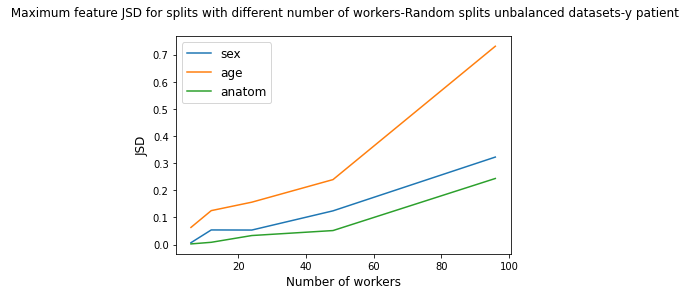

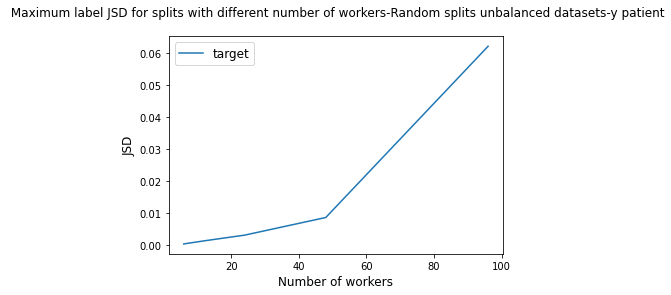

In [202]:
dfs = [jsd_uds_w6_patient,jsd_uds_w12_patient,jsd_uds_w24_patient,jsd_uds_w48_patient,jsd_uds_w96_patient]
workers = [6,12,24,48,96]
metrics_uds_patient={'sex_dist':[[],[]],'age_dist':[[],[]],'anatom_dist':[[],[]],'target_dist':[[],[]]}

for key in metrics_uds_patient:
    
    metrics_uds_patient[key][0]=[df[key].min() for df in dfs]
    metrics_uds_patient[key][1]=[df[key].max() for df in dfs]
    
for key in metrics_uds_patient:
    if(key!='target_dist'):
        plt.plot(workers,metrics_uds_patient[key][1],label=key.split("_")[0])

t = " Maximum feature JSD for splits with different number of workers-Random splits unbalanced datasets-split by patient"
plt.title(t, pad=20)
plt.legend(fontsize=12)
plt.xlabel("Number of workers", fontsize=12)
plt.ylabel("JSD", fontsize=12)
plt.show()

plt.plot(workers,metrics_uds_patient['target_dist'][1],label='target')

t = " Maximum label JSD for splits with different number of workers-Random splits unbalanced datasets-split by patient"
plt.title(t, pad=20)
plt.legend(fontsize=12)
plt.xlabel("Number of workers", fontsize=12)
plt.ylabel("JSD", fontsize=12)
plt.show()

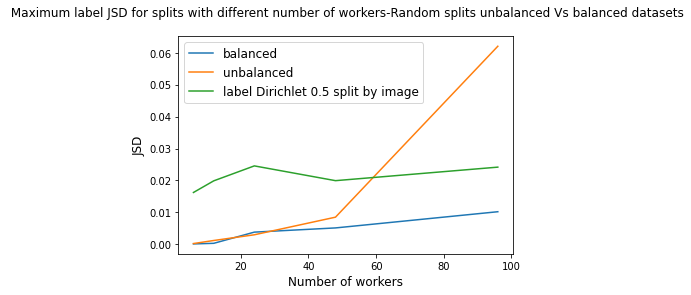

In [234]:
#We add split by image with label distribution following Dirichlet 0.5 as a base case/reference for non iid data/data split
#heterogeneity 
plt.plot(workers,metrics_iid_patient['target_dist'][1],label='balanced')
plt.plot(workers,metrics_uds_patient['target_dist'][1],label='unbalanced')
plt.plot(workers,metrics_da0_5_image['target_dist'][1],label='label Dirichlet 0.5 split by image')

t = " Maximum label JSD for splits with different number of workers-Random splits unbalanced Vs balanced datasets"
plt.title(t, pad=20)
plt.legend(fontsize=12)
plt.xlabel("Number of workers", fontsize=12)
plt.ylabel("JSD", fontsize=12)
plt.show()

- The label distribution can have imbalanced labels, for large number of clients the divergence can be six times higher than  observed with random splits and balanced dataset sizes. 
- This does not apply for number of client less than 48, the divergence between balanced and unbalanced datasets in terms of label distribution is small- so labels are impacted once unbalanced data is created for a large number of clients

## Method 4: Feature Distribution Splits (non-IID)
### Performed as real-world scenarios, splits by Patient ID
- Splits specified by an unbalance ratio for a metadata feature. Unbalance ratio will control the split of the feature value.
-  Data size is the same across workers.

In [209]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)



n_workers = 96
#lower data size set to be 20% of average data size
random_sc = FeatureLabelUnbalancedScenarioFL(split_by='patient_id',feature_name='sex',f_unbal_ratio=1)
random_workers_split6 = create_flworker_set(train_loader,n_workers,random_sc,1)
jsd_fs_w96_patient = ws_jensen_shanon_distance(train_loader,random_workers_split6,output='workers_distances')

In [210]:
workers_feature_label_dist(random_workers_split6)

,sex (female),age_approx (mean),age_approx (std),upper extremity,lower extremity,torso,unknown,head/neck,palms/soles,oral/genital,target (1),Total patients
0,0.398148,57.731481,15.683557,0.129630,0.194444,0.564815,0.037037,0.074074,0.000000,0.000000,0.018519,14
1,0.264706,50.294118,10.686383,0.083333,0.245098,0.598039,0.014706,0.049020,0.009804,0.000000,0.024510,14
2,0.354978,54.870130,10.903949,0.134199,0.264069,0.519481,0.008658,0.073593,0.000000,0.000000,0.012987,14
3,0.287879,51.174242,9.055803,0.106061,0.257576,0.522727,0.015152,0.098485,0.000000,0.000000,0.022727,14
4,0.669355,52.459677,13.741161,0.153226,0.233871,0.556452,0.016129,0.032258,0.008065,0.000000,0.032258,14
...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.597285,52.149321,9.989556,0.194570,0.248869,0.457014,0.009050,0.081448,0.004525,0.004525,0.022624,14
92,0.309645,52.512690,9.430524,0.121827,0.213198,0.593909,0.020305,0.050761,0.000000,0.000000,0.010152,14
93,0.668571,53.371429,14.285846,0.188571,0.148571,0.622857,0.005714,0.034286,0.000000,0.000000,0.034286,14
94,0.147727,53.920455,10.912255,0.079545,0.238636,0.632576,0.003788,0.022727,0.015152,0.007576,0.026515,14


In [211]:
jsd_fs_w96_patient['sex_dist'].max()

0.23492453043634715

In [212]:
jsd_fs_w96_patient['target_dist'].max()

0.010226963112096065

In [217]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)



n_workers = 6
#lower data size set to be 20% of average data size
random_sc = FeatureLabelUnbalancedScenarioFL(split_by='patient_id',feature_name='age_approx',f_unbal_ratio=1)
random_workers_split6 = create_flworker_set(train_loader,n_workers,random_sc,1)
jsd_as_w6_patient = ws_jensen_shanon_distance(train_loader,random_workers_split6,output='workers_distances')

In [222]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)



n_workers = 12
#lower data size set to be 20% of average data size
random_sc = FeatureLabelUnbalancedScenarioFL(split_by='patient_id',feature_name='age_approx',f_unbal_ratio=1)
random_workers_split6 = create_flworker_set(train_loader,n_workers,random_sc,1)
jsd_as_w12_patient = ws_jensen_shanon_distance(train_loader,random_workers_split6,output='workers_distances')

In [223]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)



n_workers = 24
#lower data size set to be 20% of average data size
random_sc = FeatureLabelUnbalancedScenarioFL(split_by='patient_id',feature_name='age_approx',f_unbal_ratio=1)
random_workers_split6 = create_flworker_set(train_loader,n_workers,random_sc,1)
jsd_as_w24_patient = ws_jensen_shanon_distance(train_loader,random_workers_split6,output='workers_distances')

In [224]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)



n_workers = 48
#lower data size set to be 20% of average data size
random_sc = FeatureLabelUnbalancedScenarioFL(split_by='patient_id',feature_name='age_approx',f_unbal_ratio=1)
random_workers_split6 = create_flworker_set(train_loader,n_workers,random_sc,1)
jsd_as_w48_patient = ws_jensen_shanon_distance(train_loader,random_workers_split6,output='workers_distances')

In [225]:
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)



n_workers = 96
#lower data size set to be 20% of average data size
random_sc = FeatureLabelUnbalancedScenarioFL(split_by='patient_id',feature_name='age_approx',f_unbal_ratio=1)
random_workers_split6 = create_flworker_set(train_loader,n_workers,random_sc,1)
jsd_as_w96_patient = ws_jensen_shanon_distance(train_loader,random_workers_split6,output='workers_distances')

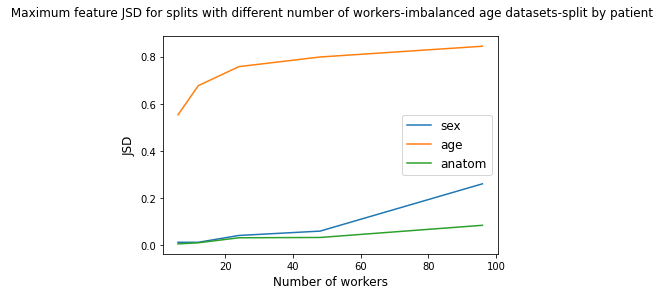

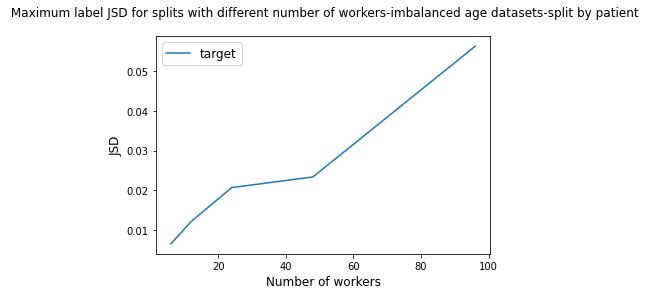

In [226]:
dfs = [jsd_as_w6_patient,jsd_as_w12_patient,jsd_as_w24_patient,jsd_as_w48_patient,jsd_as_w96_patient]
workers = [6,12,24,48,96]
metrics_as_patient={'sex_dist':[[],[]],'age_dist':[[],[]],'anatom_dist':[[],[]],'target_dist':[[],[]]}

for key in metrics_as_patient:
    
    metrics_as_patient[key][0]=[df[key].min() for df in dfs]
    metrics_as_patient[key][1]=[df[key].max() for df in dfs]
    
for key in metrics_as_patient:
    if(key!='target_dist'):
        plt.plot(workers,metrics_as_patient[key][1],label=key.split("_")[0])

t = " Maximum feature JSD for splits with different number of workers-imbalanced age datasets-split by patient"
plt.title(t, pad=20)
plt.legend(fontsize=12)
plt.xlabel("Number of workers", fontsize=12)
plt.ylabel("JSD", fontsize=12)
plt.show()

plt.plot(workers,metrics_as_patient['target_dist'][1],label='target')

t = " Maximum label JSD for splits with different number of workers-imbalanced age datasets-split by patient"
plt.title(t, pad=20)
plt.legend(fontsize=12)
plt.xlabel("Number of workers", fontsize=12)
plt.ylabel("JSD", fontsize=12)
plt.show()

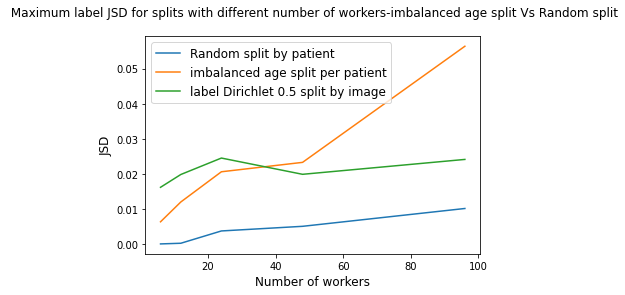

In [232]:
plt.plot(workers,metrics_iid_patient['target_dist'][1],label='Random split by patient')
plt.plot(workers,metrics_as_patient['target_dist'][1],label='imbalanced age split per patient')
plt.plot(workers,metrics_da0_5_image['target_dist'][1],label='label Dirichlet 0.5 split by image')

t = " Maximum label JSD for splits with different number of workers-imbalanced age split Vs Random split"
plt.title(t, pad=20)
plt.legend(fontsize=12)
plt.xlabel("Number of workers", fontsize=12)
plt.ylabel("JSD", fontsize=12)
plt.show()

- The split per age non-iid scenario creates large divergence, particularly for a large number of workers e.g. 96 clients. 
- The split per sex non-iid scenario does not generate a large divergence.
- For workers less 48, the divergence between client and train dataset is similar to results when we split per image and simulate label probabilities using Dirichlet with alpha between 0.5 and 1. Essentially label imbalance scenario is similar in divergence to feature split for Age because the age feature impacts the distribution of label (elderly as more susceptible to melanoma)


## Conclusion: 
- Federated Learning will be explored for IID scenarios with Dirichlet infinity and split by Image ID only.
- Non-IID scenarios will be explored as split by Image ID and Dirichlet 0.5 for label distribution
- Finally we will compare the real-world cases of heterogeneity that come from feature imbalance on patient ID split by age 